In [42]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
import emoji
import nltk
import nest_asyncio
import string
import time
import glob

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

nest_asyncio.apply()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
pd.set_option('display.max_columns', None)

In [3]:
# If you can still run Tweepy, use this for accessing it. Just change the path to your access.json
path = 'C:/Users/User/Desktop/Year 3 Sem 3/social-media-computing-twitter/'

secrets = json.loads(open(path+'access.json').read())

consumer_key = secrets['consumer_key'].replace('"', '')
consumer_secret = secrets['consumer_secret'].replace('"', '')
access_token = secrets['access_token'].replace('"', '')
access_token_secret = secrets['access_token_secret'].replace('"', '')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

try:
    api.verify_credentials()
    print("Authentication Successful")
except:
    print("Authentication Error")


Authentication Successful


In [4]:
# api.rate_limit_status()

# Load Data

In [134]:
# Returns 3 dataframes for:
# 1. User timeline tweets obtained with Tweepy
# 2. Scraped data which contains the views of the tweets using Selenium
# 3. 30 day historical data that tracks followers, followings, and tweets from Social Blade
def load_all_tweets_views_historical_json():
    # User Timeline Tweets
    dataframes = []
    pattern = r"UserTimeline_(\w+)\.json"
    
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match is not None:
            temp_df = pd.read_json(f"data/{filename}", convert_dates = ["created_at"])
            temp_df["username"] = match.group(1)
            dataframes.append(temp_df)
    
    results = pd.concat(dataframes)
    results = results[['username'] + list(results.columns[:-1])]
    
    # Scraped data for views 
    dataframes = []
    pattern = r"output_selenium_(\w+)\.json"
    for filename in os.listdir("selenium_scraper"):
        match = re.search(pattern, filename)
        if match is not None:
            temp_df = pd.read_json(f"selenium_scraper/{filename}", orient="index", convert_dates = ["created_at"])
            temp_df["username"] = match.group(1)
            dataframes.append(temp_df)

    results_view = pd.concat(dataframes)
    results_view = results_view[['username'] + list(results_view.columns[:-1])].reset_index().rename(columns={'index':'link'})

    # 30 day historical data
    dataframes = []
    pattern = r"Historical30d_(\w+)\.csv"
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match:
            profile = match.group(1)
            filepath = os.path.join("data", filename)
            df = pd.read_csv(filepath)
            df['username'] = profile  # Add a 'Profile' column to identify the data source
            dataframes.append(df)
    results_historical = pd.concat(dataframes, ignore_index=True)
    results_historical = results_historical[['username'] + list(results_historical.columns[:-1])]

    results_historical['date'] = pd.to_datetime(results_historical['date'])
    results_historical['followers'] = results_historical[' followers']
    results_historical['following'] = results_historical[' following']
    results_historical['tweets'] = results_historical[' tweets']
    
    results_historical.drop([' followers', ' following', ' tweets'], axis=1, inplace=True)

    return results, results_view, results_historical

df, df_views, df_historical = load_all_tweets_views_historical_json()
df_historical



,username,date,followers,following,tweets
0,HardDriveMag,2023-05-03,321290,939,13258
1,HardDriveMag,2023-05-04,321260,939,13264
2,HardDriveMag,2023-05-05,321226,938,13270
3,HardDriveMag,2023-05-06,321229,939,13275
4,HardDriveMag,2023-05-07,321252,939,13277
...,...,...,...,...,...
111,TheOnion,2023-05-29,11780112,6,98702
112,TheOnion,2023-05-30,11779278,6,98723
113,TheOnion,2023-05-31,11777176,6,98753
114,TheOnion,2023-06-01,11775909,6,98784


# Process Data

In [75]:
# Pulls "day of the week" and "hour of the day" from `created_at`
def process_dates(df):
    temp_df = df.copy()
    
    temp_df["day_of_week"] = df["created_at"].dt.day_name()
    temp_df["hour_of_day"] = df["created_at"].dt.hour
    
    return temp_df

df = process_dates(df)
df

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,21
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,20
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN,Friday,20
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,19
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1619795017714786307, 'id_str...",NaN,Sunday,20
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20
3248,TheOnion,2023-01-29 20:00:10+00:00,1619787507414990

In [76]:
def text_clean(text):
    # remove hashtags as they do not have any effect on sentiment analysis
    text = re.sub(r'#\w+', '', str(text))

    # remove mentions as they do not have any effect on sentiment analysis
    text = re.sub(r'@\w+', '', str(text))

    # remove the word 'RT' as they do only indicate retweets 
    text = ' '.join(word for word in text.split() if word.lower() != 'rt')

    # removes any occurences of any URLs in the text because they do not affect sentiment analysis as well
    text = re.sub(r'\b\w*http\w*\S*', '', str(text))

    # remove any occurrences of any punctuation characters to only filter just the words. 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) 

    # lower case for all words to help with reducing noise 
    text = str(text).lower() 

    # convert emojis to words instead for use in identifying sentiments using emoji. Also removing the ":" and adding a space after the emoji to get only the string of the emoji used
    text = emoji.demojize(str(text))
    text = text.replace(":"," ")
    text = ' '.join(text.split())

    return text

cleaned = lambda x: text_clean(x)

df['cleaned_text'] = pd.DataFrame(df['text'].apply(cleaned))
my_column = df.pop('cleaned_text')
df.insert(5, 'cleaned_text', my_column)
df

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,ea honors pride month by announcing one of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,21
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",the day i stopped following cain i didnt think...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,20
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,atheists can you tackle this impossible logic ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN,Friday,20
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,breaking nintendo announces mario will “try a ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,19
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,yeah us jerma fans don’t really have object pe...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,nick bosa the defensive end fully utilizes his...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,nick bosa quietly admits to offensive tackle t...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1619795017714786307, 'id_str...",NaN,Sunday,20
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.

## Metrics for Monitoring

### Impressions  

Measures the number of views a tweet was seen on Twitter. This data was scraped using Selenium and is stored in our dataset. 

### Audience Growth Rate

Measures the change in followers of the user over a certain period of time. This data was obtained from Social Blade and is stored in our dataset. 

Formula: Audience Growth Rate = ((Ending Followers - Starting Followers) / Starting Followers) * 100

### Average Engagement Rate
Measures the number of engagements a tweet gets, to the total number of followers. 

Formula: 
Average Engagement Rate = (likes + shares) / (total followers)

In [77]:
def process_avg_engagement_rate(df):
    temp_df = df.copy()
    
    temp_df["avg_engagement_rate"] = temp_df.apply(lambda row : (row["favorite_count"] + row["retweet_count"]) / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_avg_engagement_rate(df)

### Amplification Rate
Measures the ratio of shares per post to the total number of overall followers.

Formula: Amplification Rate = (shares) / (total followers)

In [78]:
def process_amplification_rate(df): 
    temp_df = df.copy()
    
    temp_df["amplification_rate"] = temp_df.apply(lambda row : row["retweet_count"] / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_amplification_rate(df)

### Tweet Sentiment Score

Measures the Sentiment score of the tweet. Allows us to track the sentiment of the tweet that is published by the author. VADER Sentiment Analysis is used for the scoring. 

In [79]:
def process_tweet_sentiment(df): 
    temp_df = df.copy()
    sid = SentimentIntensityAnalyzer()
    temp_df["tweet_VADER_sentiment"] = temp_df['cleaned_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return temp_df

df = process_tweet_sentiment(df)

# Basic Functions

In [80]:
# Given a pandas series, return the link of the tweet
def get_tweet_link(series):
    username = series["user"]["screen_name"]
    return f"https://twitter.com/{username}/status/{series['id']}"

tweet_link = get_tweet_link(df.iloc[0])
tweet_link

'https://twitter.com/HardDriveMag/status/1664738765376573442'

In [81]:
def find_retweets(df):
    return df[df["retweeted_status"].notnull()]

df_retweets = find_retweets(df)
df_retweets

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",the day i stopped following cain i didnt think...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,20,0.000205,0.000205,-0.5719
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,atheists can you tackle this impossible logic ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN,Friday,20,0.000400,0.000400,0.6705
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,yeah us jerma fans don’t really have object pe...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,18,0.000475,0.000475,-0.6249
5,HardDriveMag,2023-06-02 17:46:29+00:00,1664689958307725313,1664689958307725312,RT @HardDriveMag: @elonmusk Elon Musk’s Daught...,elon musk’s daughter tells him she will be cut...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,74,0,False,False,0.0,en,{'created_at': 'Fri Jun 02 17:31:55 +0000 2023...,NaN,NaN,NaN,NaN,Friday,17,0.000230,0.000230,-0.1280
9,HardDriveMag,2023-06-02 16:15:23+00:00,1664667033278074881,1664667033278074880,RT @jothwip: It's still hard to believe it's b...,its still hard to believe its been 20 years si...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,115,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:02:57 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,16,0.000357,0.000357,-0.7269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,TheOnion,2023-04-21 15:23:33+00:00,1649433698528370690,1649433698528370688,RT @KartoonistKelly: I call out the anniversar...,i call out the anniversary celebration ruiners...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,39,0,False,False,0.0,en,{'created_at': 'Thu Apr 20 17:53:31 +0000 2023...,NaN,NaN,NaN,NaN,Friday,15,0.000003,0.000003,0.0000
1336,TheOnion,2023-04-13 16:07:54+00:00,1646545758059896832,1646545758059896832,RT @KartoonistKelly: Class.\nMy latest:\nhttps...,class my latest,False,"{'hashtags': [], 'symbols': [], 'user_mentions...

In [82]:
def find_not_retweets(df):
    return df[df["retweeted_status"].isna()]

df_not_retweets = find_not_retweets(df)
df_not_retweets

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,ea honors pride month by announcing one of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,21,0.024750,2.091453e-03,0.6908
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,breaking nintendo announces mario will “try a ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,19,0.070070,7.059430e-03,0.0000
6,HardDriveMag,2023-06-02 17:31:55+00:00,1664686295157813248,1664686295157813248,@elonmusk Elon Musk’s Daughter Tells Him She W...,elon musk’s daughter tells him she will be cut...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.664615e+18,1.664615e+18,44196397.0,44196397.0,elonmusk,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,74,779,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,17,0.002647,2.296254e-04,-0.1280
7,HardDriveMag,2023-06-02 17:26:16+00:00,1664684871132774409,1664684871132774400,Diablo Fans Happy Blizzard Kept Iconic Feature...,diablo fans happy blizzard kept iconic feature...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,176,1600,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1664684868138041372, 'id_str...",NaN,Friday,17,0.005511,5.461361e-04,0.5719
8,HardDriveMag,2023-06-02 17:00:54+00:00,1664678486370287628,1664678486370287616,Retired Angry Bird Diagnosed With CTE\n\nhttps...,retired angry bird diagnosed with cte,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,38,720,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,17,0.002352,1.179157e-04,-0.5106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,nick bosa the defensive end fully utilizes his...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20,0.000006,1.698947e-07,0.5520
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,nick bosa quietly admits to offensive tackle t...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media'

# Basic Statistics

### Top Tweets

In [83]:
# Top 5 tweets with most likes (favorited)
def most_liked_tweets(df, count):
    return df.sort_values(by = ["favorite_count"], ascending = False).head(count)


def most_liked_tweets_by_users(df, count = 5):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        results[username] = most_liked_tweets(df[df["username"] == username], count)
    return results
    

dfs_top5 = most_liked_tweets_by_users(df, 5)
dfs_top5["Reductress"]

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
2382,Reductress,2022-09-08 17:31:01+00:00,1567928508218736640,1567928508218736640,Cute! Queen Elizabeth's Corgis Prepare to Be B...,cute queen elizabeths corgis prepare to be bur...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,24404,212457,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1567928506117398528, 'id_str...",NaN,Thursday,17,0.776991,0.080054,0.6808
2673,Reductress,2022-08-05 22:00:43+00:00,1555675190394232834,1555675190394232832,Wow! This Middle Aged Man Fell In Love With Hi...,wow this middle aged man fell in love with his...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,5025,51690,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,22,0.186046,0.016484,0.8402
2538,Reductress,2022-08-21 16:00:25+00:00,1561382724442652673,1561382724442652672,Nice! New Collar Delivers a Shock Every Time Y...,nice new collar delivers a shock every time yo...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,3327,28908,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1561382722693627907, 'id_str...",NaN,Sunday,16,0.105743,0.010914,0.0516
1930,Reductress,2022-10-29 21:00:17+00:00,1586462954102624256,1586462954102624256,How to Pass Off Your IBS Bathroom Trips as a C...,how to pass off your ibs bathroom trips as a c...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1663,19245,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1586462952747573250, 'id_str...",NaN,Saturday,21,0.068586,0.005455,0.3182
1010,Reductress,2023-02-11 22:00:23+00:00,1624528804377989120,1624528804377989120,Quadruple Threat! Barbra Streisand Has a Knife...,quadruple threat barbra streisand has a knife,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1504,14852,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1624528803153252354, 'id_str...",NaN,Saturday,22,0.053654,0.004934,-0.5267


In [84]:
get_tweet_link(dfs_top5["HardDriveMag"].iloc[0])

'https://twitter.com/HardDriveMag/status/1531401966567493634'

In [85]:
def find_average_by_users(dataframes, column_name, avg_type = "mean"):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        if avg_type == "mean":
            results[username] = df[df["username"] == username][column_name].mean()
        elif avg_type == "median":
            results[username] = df[df["username"] == username][column_name].median()
    return results


print("Mean favorites   : ")
for username, mean in find_average_by_users(df_not_retweets, "favorite_count", "mean").items():
    print(f"{username:16} : {mean:.2f}")

print("-----\n")

print("Median favorites : ")
for username, median in find_average_by_users(df_not_retweets, "favorite_count", "median").items():
    print(f"{username:16} : {median}")

Mean favorites   : 
HardDriveMag     : 2877.49
Reductress       : 707.47
TheBabylonBee    : 6833.81
TheOnion         : 1848.31
-----

Median favorites : 
HardDriveMag     : 1545.0
Reductress       : 385.0
TheBabylonBee    : 3295.0
TheOnion         : 805.0


## Mean and Median stats

### Impressions

In [117]:
usernames = pd.unique(df["username"])
results_mean = {}
results_median = {}
    
for username in usernames:
    results_mean[username] = df_views[df_views["username"] == username]['views'].mean()
    results_median[username] = df_views[df_views["username"] == username]['views'].median()

print("Mean Impressions   : ")
for username, mean in results_mean.items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median Impressions   : ")
for username, median in results_median.items():
    print(f"{username:16} : {median:.6f}")


Mean Impressions   : 
HardDriveMag     : 314249.483395
Reductress       : 68456.113001
TheBabylonBee    : 835498.958589
TheOnion         : 384517.104242
-----

Median Impressions   : 
HardDriveMag     : 102845.500000
Reductress       : 48133.000000
TheBabylonBee    : 456122.500000
TheOnion         : 277243.000000


### Engagement Rate

In [113]:
print("Mean engagement rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "avg_engagement_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median engagement rate   : ")
for username, median in find_average_by_users(df_not_retweets, "avg_engagement_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean engagement rate   : 
HardDriveMag     : 0.009977
Reductress       : 0.002555
TheBabylonBee    : 0.002942
TheOnion         : 0.000172
-----

Median engagement rate   : 
HardDriveMag     : 0.005253
Reductress       : 0.001389
TheBabylonBee    : 0.001422
TheOnion         : 0.000073


### Amplification Rate

In [114]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "amplification_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "amplification_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
HardDriveMag     : 0.001048
Reductress       : 0.000234
TheBabylonBee    : 0.000394
TheOnion         : 0.000015
-----

Median amplification rate   : 
HardDriveMag     : 0.000416
Reductress       : 0.000121
TheBabylonBee    : 0.000163
TheOnion         : 0.000005


### Tweet Sentiment Score

In [115]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "tweet_VADER_sentiment", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "tweet_VADER_sentiment", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
HardDriveMag     : -0.005993
Reductress       : 0.039510
TheBabylonBee    : -0.001592
TheOnion         : 0.005897
-----

Median amplification rate   : 
HardDriveMag     : 0.000000
Reductress       : 0.000000
TheBabylonBee    : 0.000000
TheOnion         : 0.000000


### For exporting csv file to plot dashboard.py. Uncomment to get csv. 

In [72]:
# df_not_retweets.to_csv('data_with_metrics.csv', index=False)
# df_views.to_csv('data_views.csv', index=False)

# Plots (shown in streamlit)

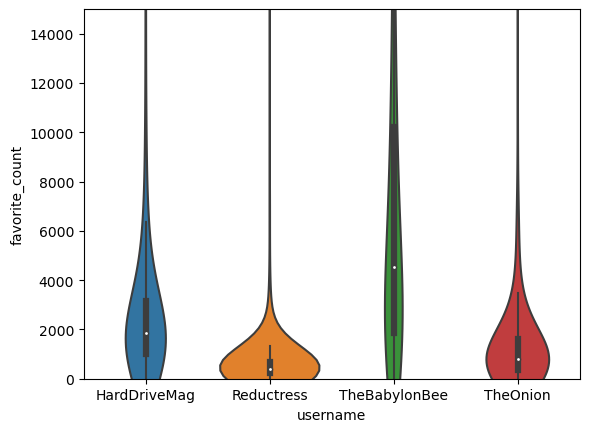

In [18]:
# Plot favorite count of each user using a violin plot
def plot_favorite_count_by_user(df):
    fig, ax = plt.subplots()
    sns.violinplot(data = df, x = "username", y = "favorite_count", gridsize = 1000)
    ax.set_ylim(0, 15000)
    plt.show()
    
    
plot_favorite_count_by_user(df_not_retweets)

In [19]:
# Plot 4 subplots of counts of tweets by hour of the day
def plot_tweet_counts(df, column_name, order):
    grid = sns.FacetGrid(data = df, col = "username", col_wrap = 2, aspect = 1.5, height = 4, sharex = False, sharey = False)
    
    grid.map(sns.countplot, column_name, order = order)
    grid.set_axis_labels(column_name, "Count")
    grid.set_titles('{col_name}')
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

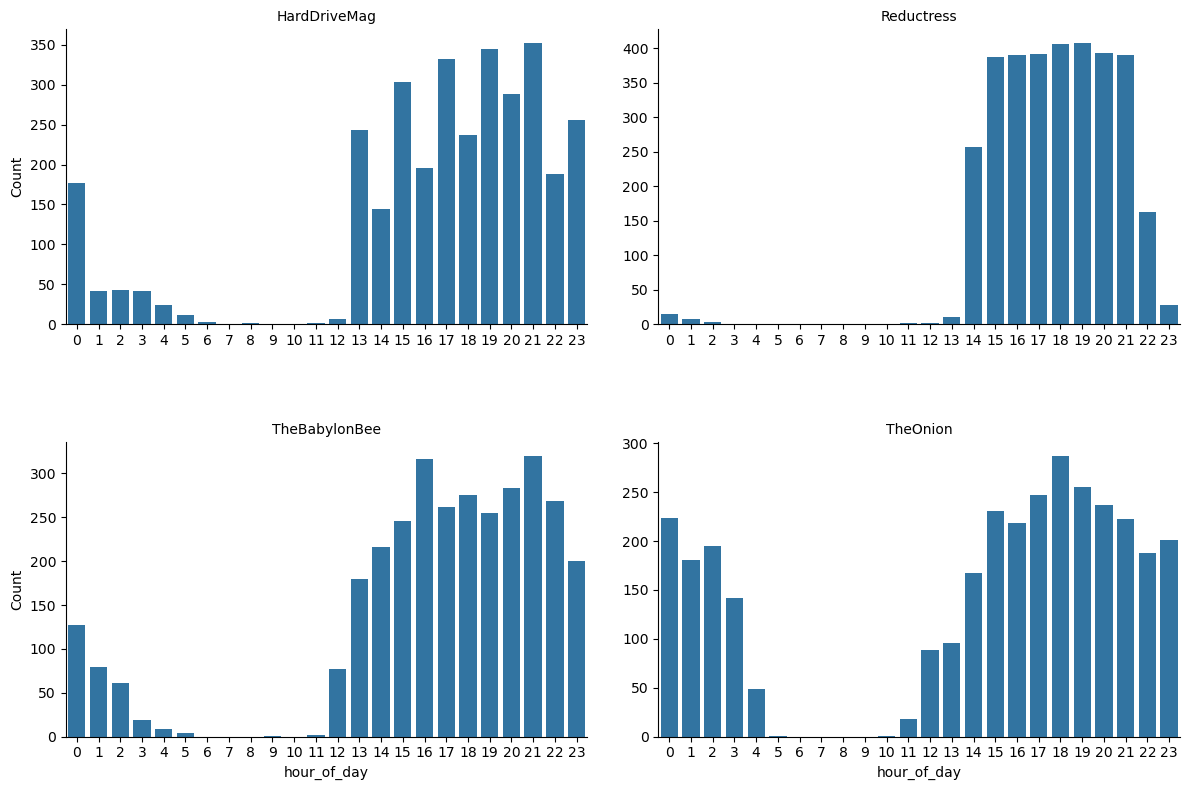

In [20]:
plot_tweet_counts(df, "hour_of_day", [i for i in range(24)])

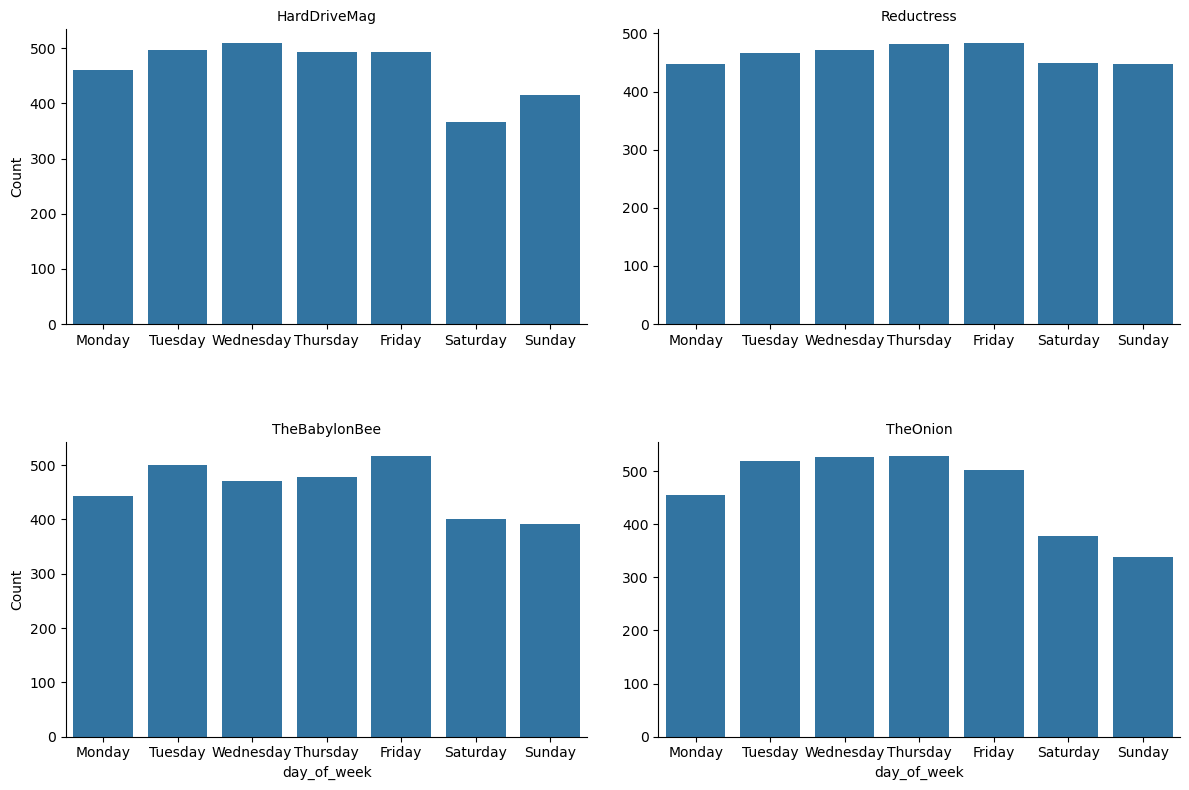

In [21]:
plot_tweet_counts(df, "day_of_week", ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

### Total Average Engagement by Time

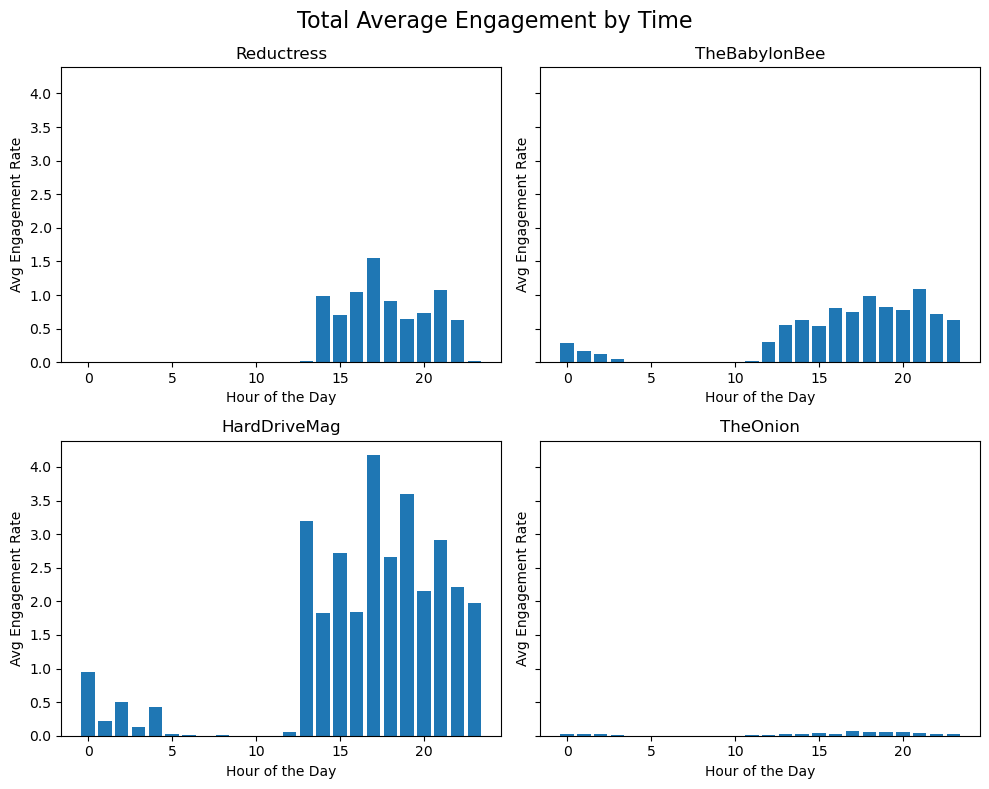

In [22]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

names = ['Reductress', 'TheBabylonBee', 'HardDriveMag', 'TheOnion']

fig.suptitle('Total Average Engagement by Time', fontsize=16)

# Plot the counts of retweets for each hour in each subplot
for i, ax in enumerate(axs.flatten()):
    subset_df = df_not_retweets[df_not_retweets['username'] == names[i]]  
    retweet_counts = subset_df.groupby('hour_of_day')['avg_engagement_rate'].sum()
    ax.bar(retweet_counts.index, retweet_counts.values)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Avg Engagement Rate')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

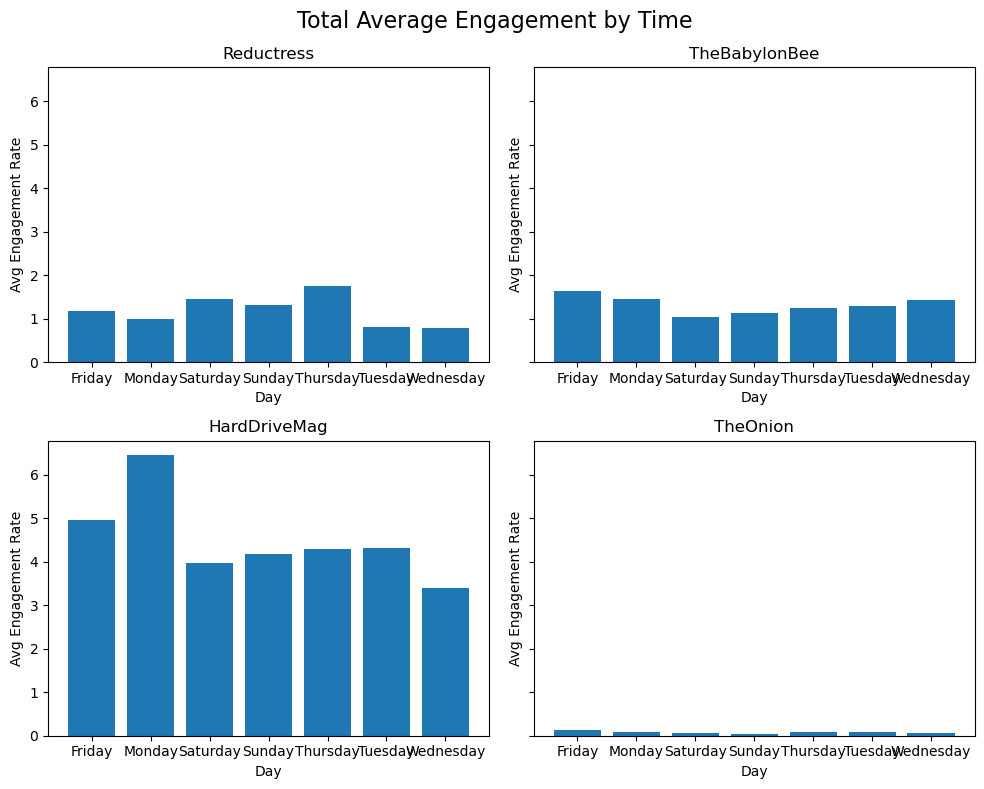

In [23]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

names = ['Reductress', 'TheBabylonBee', 'HardDriveMag', 'TheOnion']

fig.suptitle('Total Average Engagement by Time', fontsize=16)

# Plot the counts of retweets for each hour in each subplot
for i, ax in enumerate(axs.flatten()):
    subset_df = df_not_retweets[df_not_retweets['username'] == names[i]]  
    retweet_counts = subset_df.groupby('day_of_week')['avg_engagement_rate'].sum()
    ax.bar(retweet_counts.index, retweet_counts.values)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Avg Engagement Rate')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

### Net Followers across 30 days


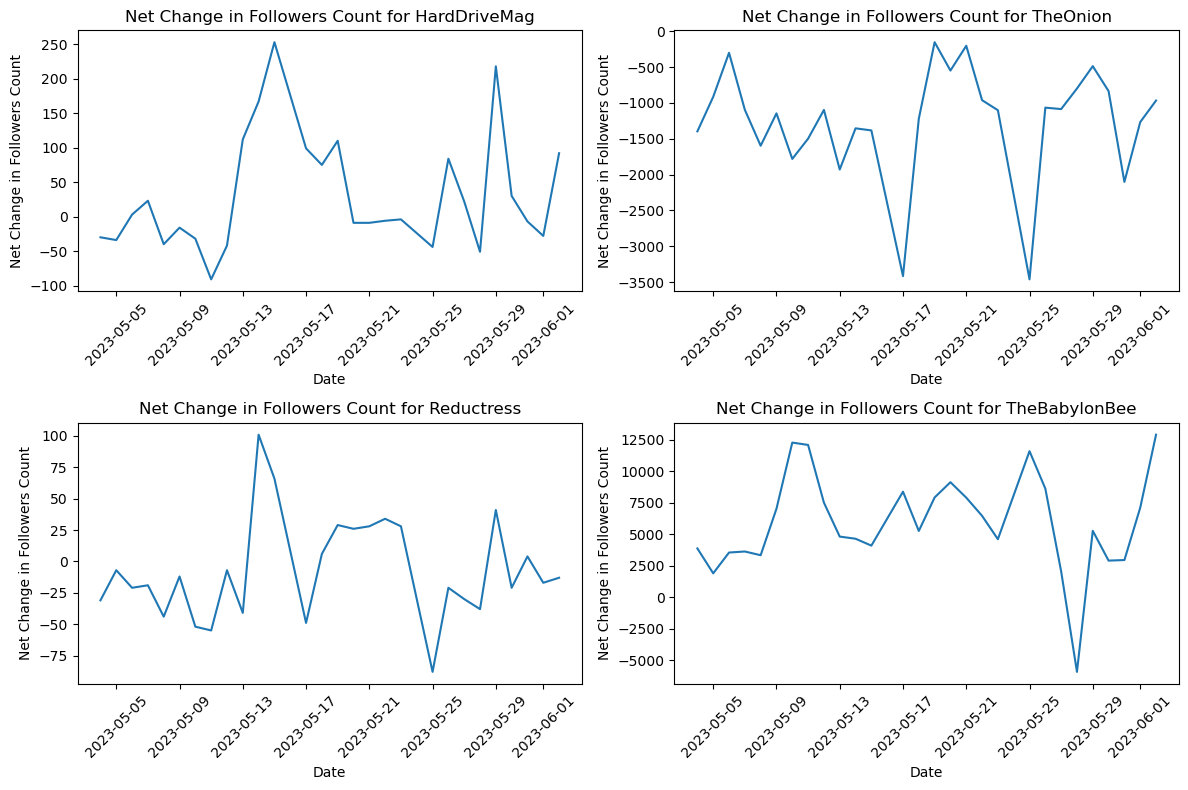

In [135]:
def plot_net_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['net_change'] = df['followers'].diff()  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['net_change'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Net Change in Followers Count')
        ax.set_title(f'Net Change in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_net_change_followers(df_historical)

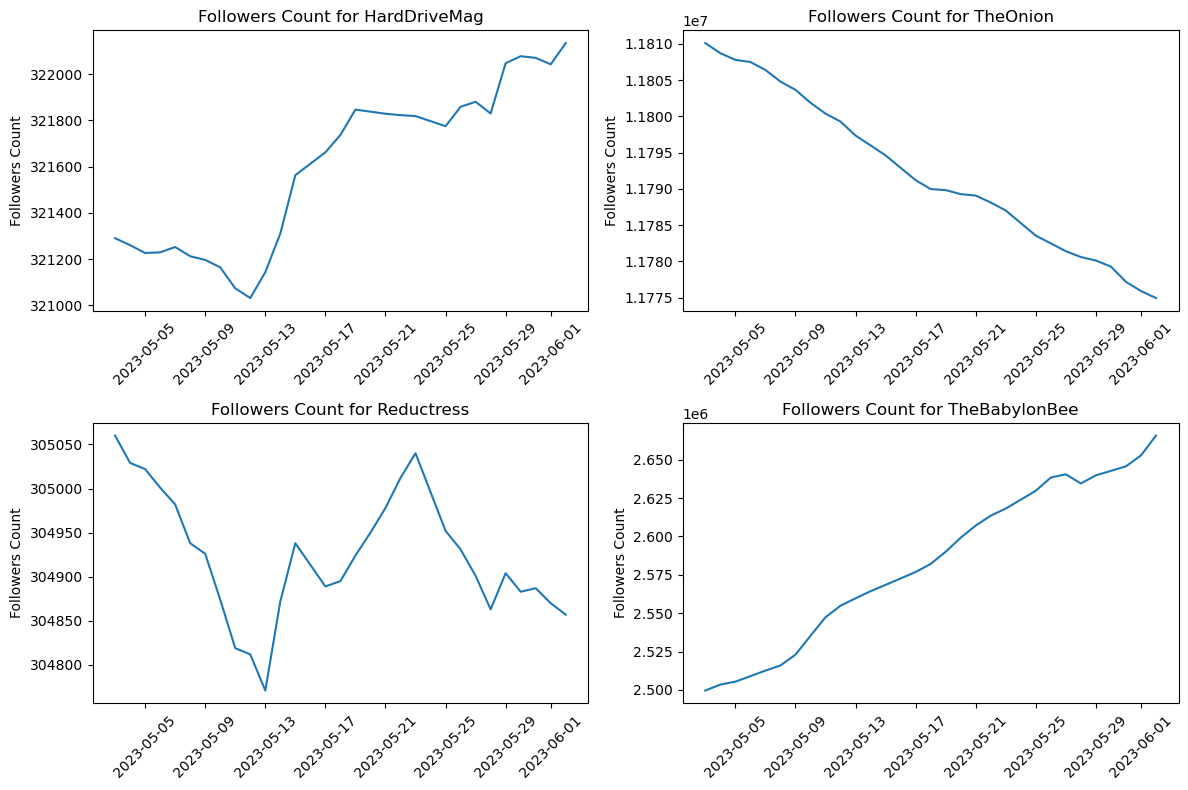

In [136]:
def plot_followers_count(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username]
        ax = axes[row, col]
        ax.plot(df['date'], df['followers'])
        ax.set_ylabel('Followers Count')
        ax.set_title(f'Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # for username in usernames:
    #     df = combined_df[combined_df['username'] == username]
    #     plt.plot(df['date'], df['followers'])
    #     plt.xlabel('Date')
    #     plt.ylabel('Followers Count')
    #     plt.title(f'Followers Count for {username}')
    #     plt.xticks(rotation=45)
    #     plt.tight_layout()
    #     plt.show()


plot_followers_count(df_historical)

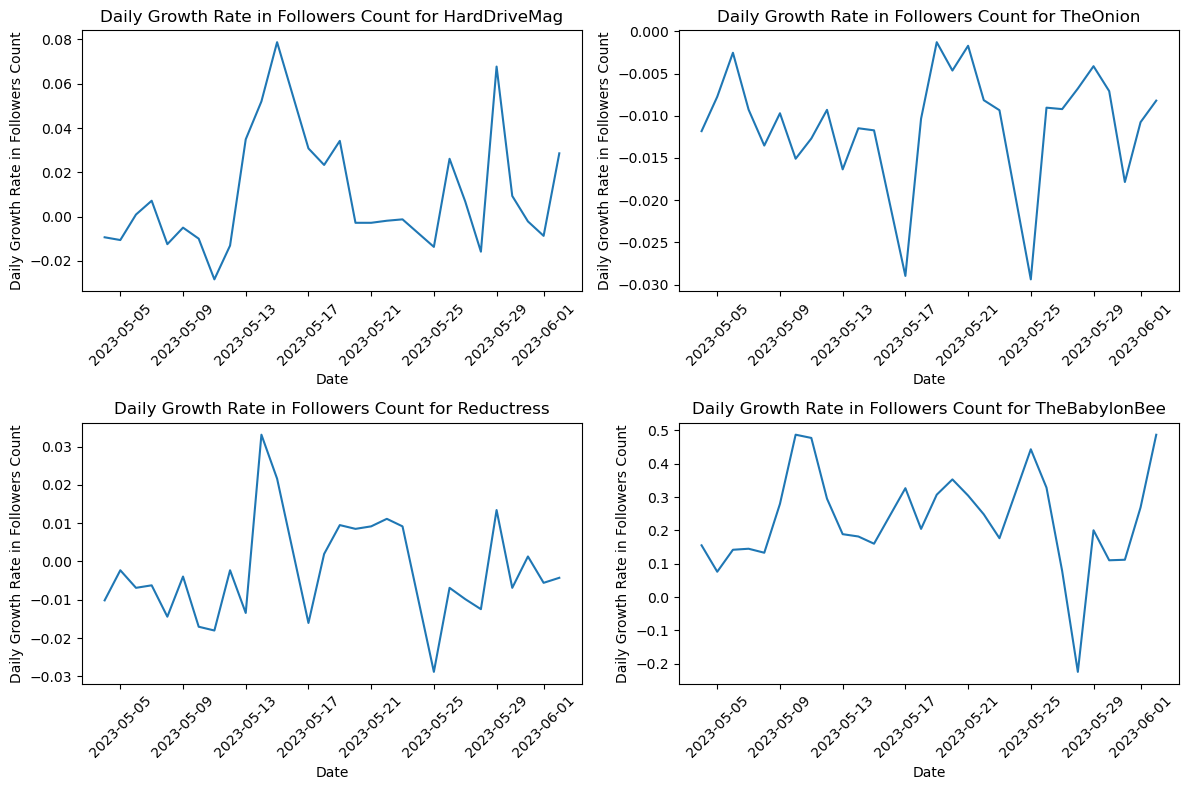

In [137]:
def plot_daily_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['growth_rate'] = df['followers'].pct_change() * 100  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['growth_rate'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily Growth Rate in Followers Count')
        ax.set_title(f'Daily Growth Rate in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_change_followers(df_historical)

In [138]:
def get_total_growth_rate_follower(df_combined):
    usernames = df_combined['username'].unique()
    df = pd.DataFrame(usernames, columns=['username'])
    total_growth_rates = {}
    for username in usernames:
        user_df = df_combined[df_combined['username'] == username]
        followers_start = user_df.iloc[0]['followers']
        followers_end = user_df.iloc[-1]['followers']
        total_growth_rate = ((followers_end - followers_start) / followers_start) * 100
        total_growth_rates[username] = total_growth_rate
    return total_growth_rates
        
list_total_growth_rate = get_total_growth_rate_follower(df_historical)

print(f"Total growth rate for followers across 30 days")
for username, growth_rate in list_total_growth_rate.items():
    print(f"{username}: {growth_rate:.2f}%")


Total growth rate for followers across 30 days
HardDriveMag: 0.26%
Reductress: -0.07%
TheBabylonBee: 6.65%
TheOnion: -0.30%
